# Analyzing the stability with the same software versions
Since we've seen that the codec, bitrate and version all have an effect on the variance of the label probabilities produced by the high level classifiers, another question to answer is **If we make sure that version, bitrate and codec are all the same, will the variance be significantly lower?**. In theory this should be the case, since the (hopefully) same input, ran through the same version of software (by different people) should produce the same output.

In [48]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

def filter_submissions(df):
    filt = df.groupby(level=0).size() > 1
    return df[filt[df.index.get_level_values(level=0)].values]

# Classifier columns to study
cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


# Load in the acousticbrainz dataset into the variable 'acousticbrainz' (V3 also include build SHA to make sure that software
# version is the same on a commit basis.
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

In [28]:
metaFeatureNames = [
    "analysis_sample_rate",
    "bit_rate",
    "codec",
    "downmix",
    "equal_loudness",
    "length",
    "lossless",
    "replay_gain"
]

highVersionFeatures = [
    "essentia",
    "essentia_build_sha",
    "essentia_git_sha",
    "extractor",
    "gaia",
    "gaia_git_sha",
    "models_essentia_git_sha"
]

lowVersionFeatures = [
    "essentia",
    "essentia_build_sha",
    "essentia_git_sha",
    "extractor"
]

for feat in highVersionFeatures:
    print(acousticbrainz[feat + '_high'].value_counts())
    print()
    

print()

for feat in lowVersionFeatures:
    print(acousticbrainz[feat + '_low'].value_counts())
    print()

2.1-beta1    1805912
Name: essentia_high, dtype: int64

8e24b98b71ad84f3024c7541412f02124a26d327    1805912
Name: essentia_build_sha_high, dtype: int64

v2.1_beta1-228-g260734a    1805912
Name: essentia_git_sha_high, dtype: int64

music 1.0    1805912
Name: extractor_high, dtype: int64

2.4-dev    1805912
Name: gaia_high, dtype: int64

857329b    1805912
Name: gaia_git_sha_high, dtype: int64

v2.1_beta1    1805912
Name: models_essentia_git_sha_high, dtype: int64


2.1-beta2    1142046
2.1-beta1     663866
Name: essentia_low, dtype: int64

2d9f1f26377add8aeb1075a9c2973f962c4f09fd    641078
70f2e5ece6736b2c40cc944ad0e695b16b925413    395517
ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b    306436
cead25079874084f62182a551b7393616cd33d87     52312
5c9e65ec81695c916afb4cba055c226bfc528ee6     37573
                                             ...  
c21bf699013b509032349ed6cc693ee6279a0082         3
52f73f7035b780910f2a0c20338a8d66a5befff1         2
e701a31cb90e26b4850a9509902d1c1cf2166013       

In [29]:
acousticbrainz[acousticbrainz['essentia_low'] == '2.1-beta2']['essentia_git_sha_low'].value_counts()

v2.1_beta2-1-ge3940c0     693390
v2.1_beta2                408097
v2.1_beta2-2-gbb40004      36729
v2.1_beta2-15-g8ccb801      2355
v2.1_beta2-3-gd5e3a6e       1210
v2.1_beta2-6-gd3e4459        138
v2.1_beta2-12-g91c6a07       127
Name: essentia_git_sha_low, dtype: int64

In [30]:
acousticbrainz[acousticbrainz['essentia_git_sha_low'] == 'v2.1_beta2-1-ge3940c0']['essentia_build_sha_low'].value_counts()

2d9f1f26377add8aeb1075a9c2973f962c4f09fd    641078
cead25079874084f62182a551b7393616cd33d87     52312
Name: essentia_build_sha_low, dtype: int64

In [31]:
acousticbrainz[acousticbrainz['essentia_build_sha_low'] == '2d9f1f26377add8aeb1075a9c2973f962c4f09fd']['essentia_git_sha_low'].value_counts()

v2.1_beta2-1-ge3940c0    641078
Name: essentia_git_sha_low, dtype: int64

So there seem to be mulitple essentia git and essentia build SHAs for the same Essentia version, now we make subsets where all these fields are the same

In [97]:
grouped = acousticbrainz.groupby(['essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'bit_rate', 'codec'])
grouped = grouped.progress_apply(filter_submissions)
variances = grouped[cols].groupby(level=[0,1,2,3,4,5]).progress_apply(get_variance)
counts = pd.DataFrame(variances.groupby(level=[0,1,2,3,4]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances = variances.groupby(level=[0,1,2,3,4]).mean()

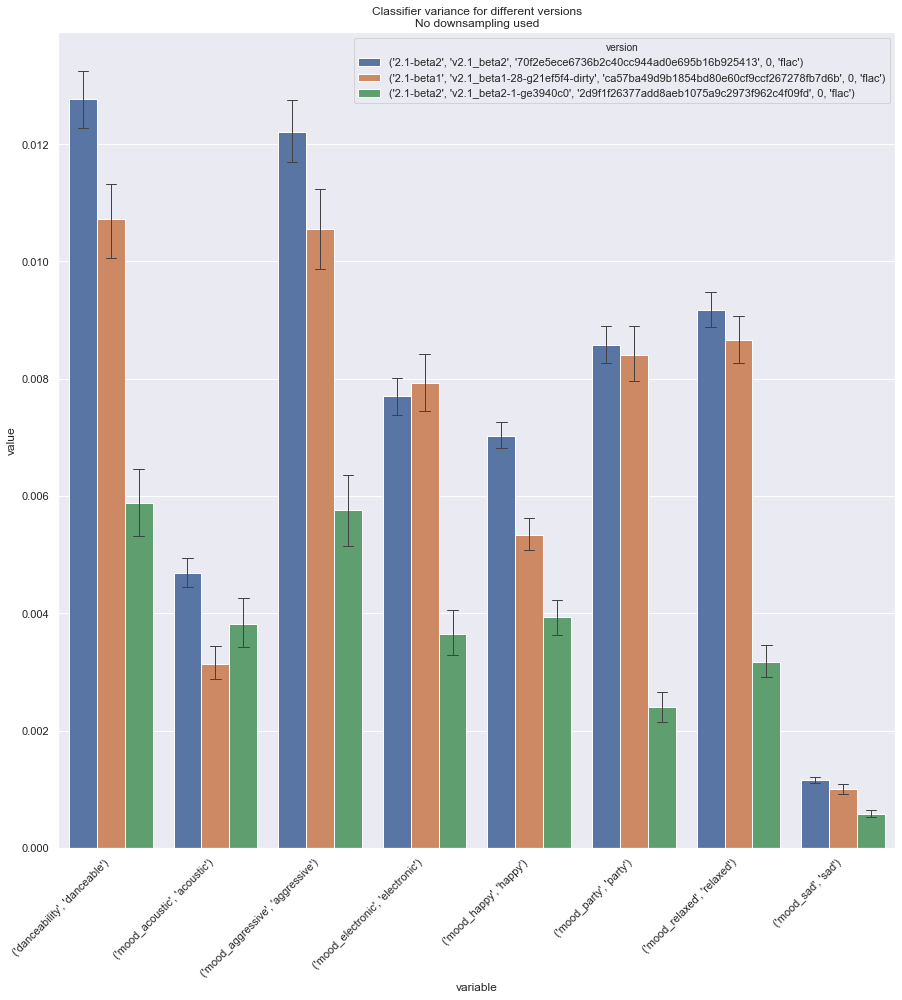

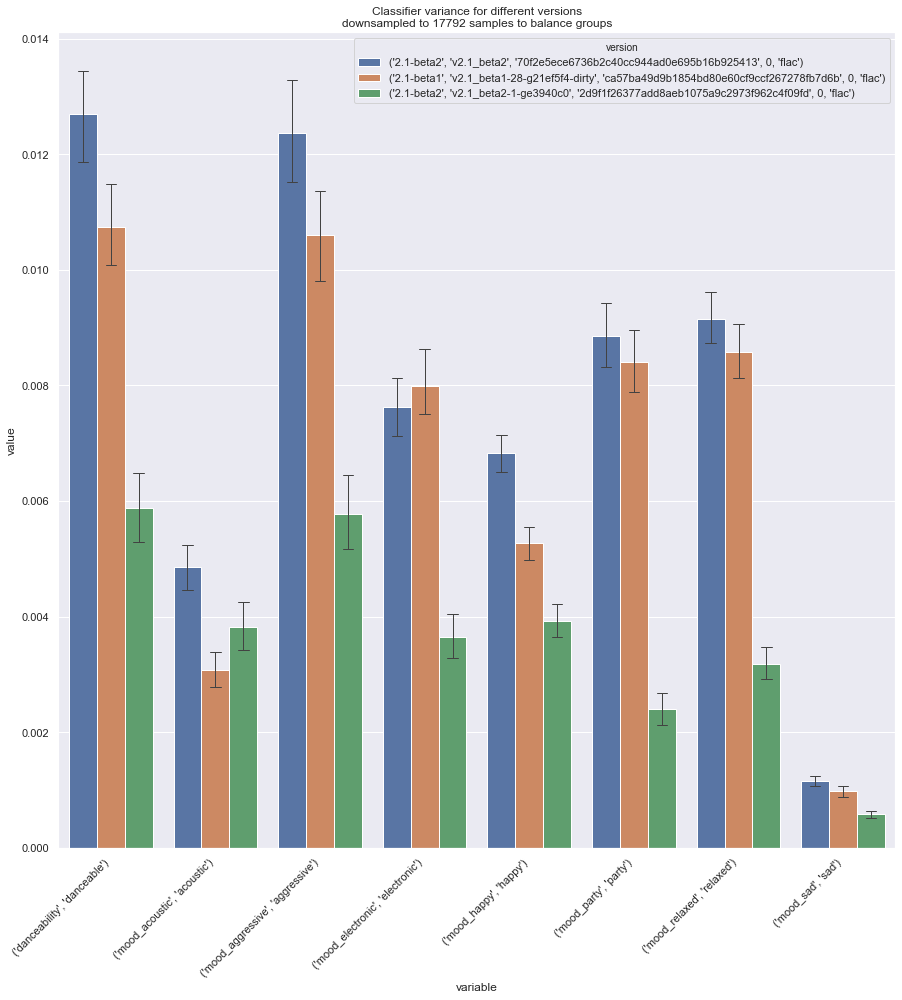

In [225]:
# Filter on version and codec combinations with more than 10,000 submissions
tocheck = list(counts[counts['count'] > 10000].index)
toplot = pd.DataFrame()
toplot_sampled = pd.DataFrame()

n_min = 20000
# Find lowest n
for comb in tocheck:
    n = len(variances.loc[comb])
    if n < n_min:
        n_min = n

for comb in tocheck:
    df = variances.loc[comb].reset_index(drop=True)
    df_sampled = df.sample(n_min)
    df['version'] = str(comb)
    df_sampled['version'] = str(comb)
    toplot = toplot.append(df)
    toplot_sampled = toplot_sampled.append(df_sampled)

toplot = toplot.melt(id_vars=['version'])
toplot_sampled = toplot_sampled.melt(id_vars=['version'])

plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different versions\nNo downsampling used")
plt.show()

plt.figure()
ax = sns.barplot(data=toplot_sampled, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different versions\ndownsampled to {n_min} samples to balance groups")
plt.show()

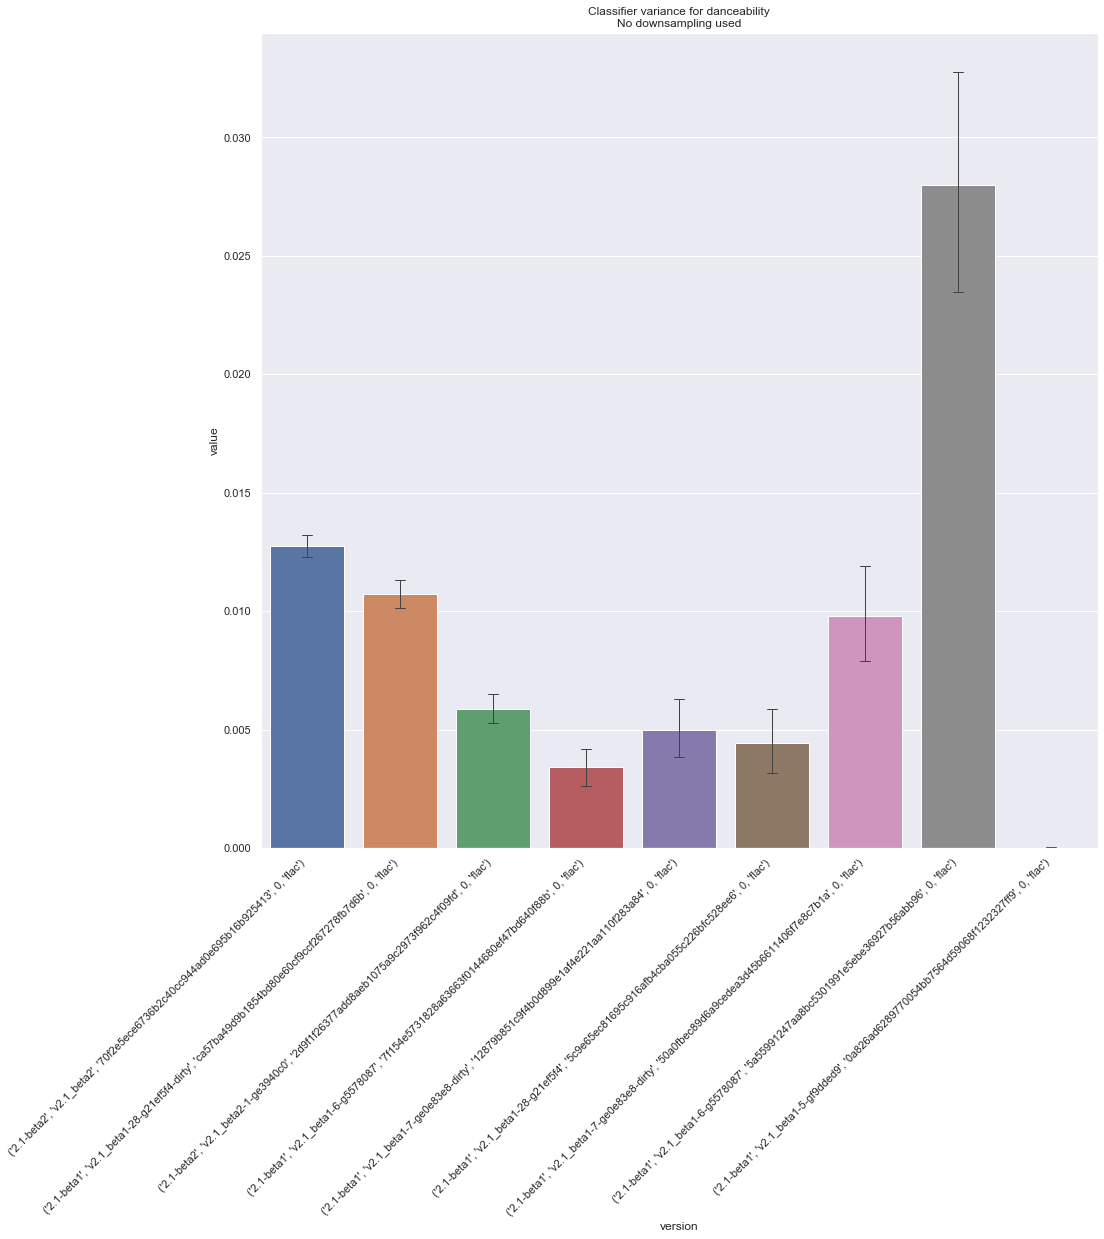

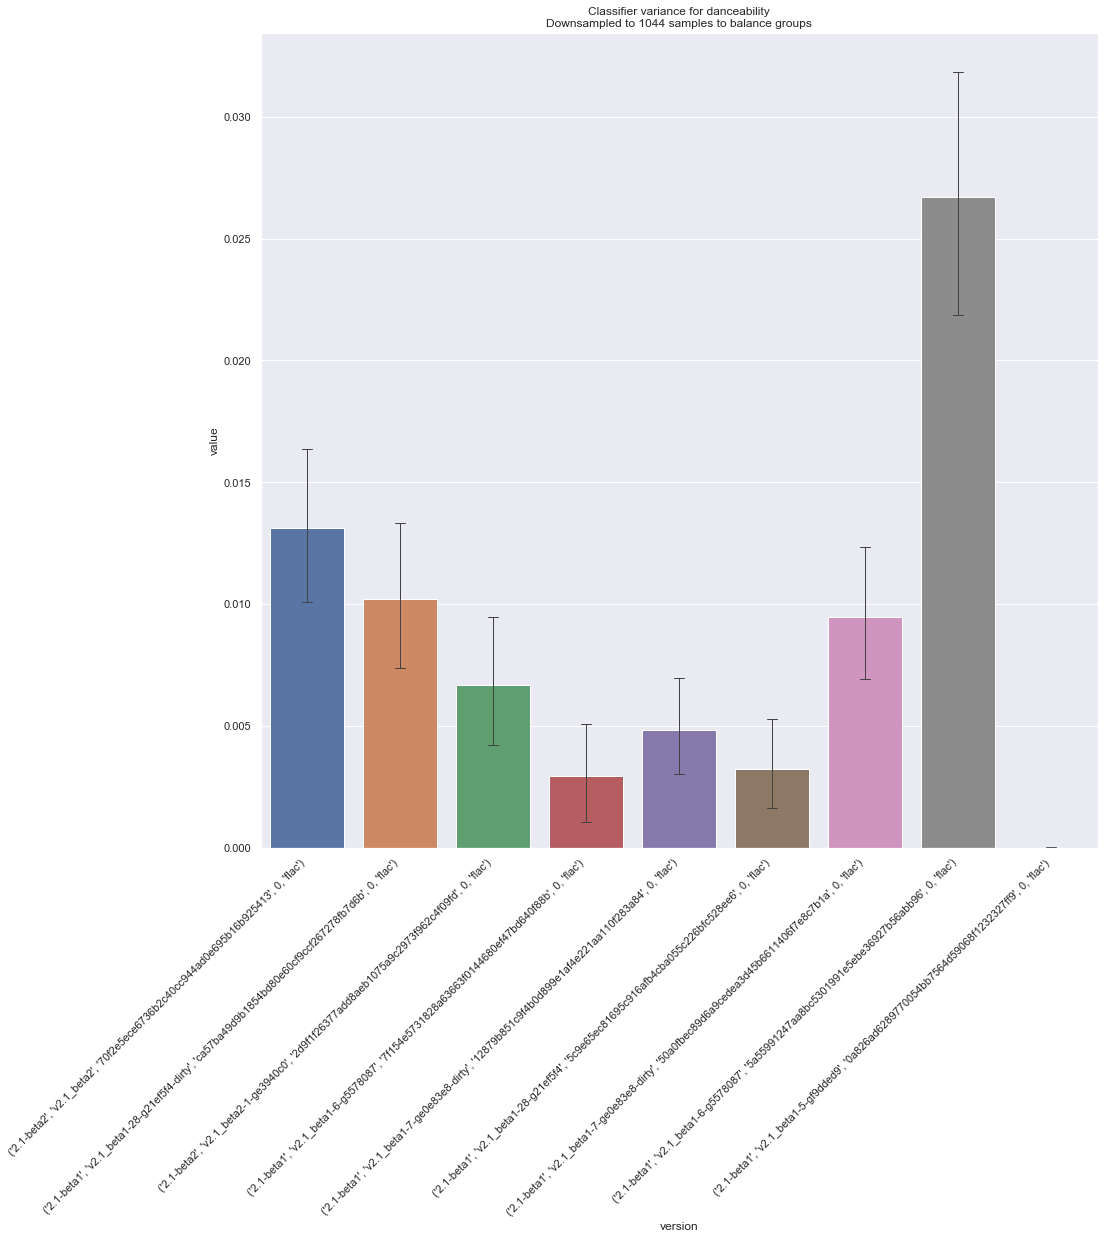

In [226]:
# Filter on version and codec combinations with more than 1,000 submissions using codec flac
tocheck = list(counts[counts['count'] > 1000].index)
tocheck = [x for x in tocheck if x[3] == 0 and x[4] == 'flac']

toplot = pd.DataFrame()
toplot_sampled = pd.DataFrame()

n_min = 20000
# Find lowest n
for comb in tocheck:
    n = len(variances.loc[comb])
    if n < n_min:
        n_min = n

for comb in tocheck:
    df = variances.loc[comb].reset_index(drop=True)
    df_sampled = df.sample(n_min)
    df['version'] = str(comb)
    df_sampled['version'] = str(comb)
    toplot = toplot.append(df)
    toplot_sampled = toplot_sampled.append(df_sampled)

toplot = toplot.iloc[:,[0,8]]
toplot = toplot.melt(id_vars=['version'])

toplot_sampled = toplot_sampled.iloc[:,[0,8]]
toplot_sampled = toplot_sampled.melt(id_vars=['version'])

plt.figure()
ax = sns.barplot(data=toplot, x='version', y='value', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for danceability\nNo downsampling used")
plt.show()

plt.figure()
ax = sns.barplot(data=toplot_sampled, x='version', y='value', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for danceability\nDownsampled to {n_min} samples to balance groups")
plt.show()